Imports

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn import svm
import hashlib
import re


#read from our local copy of the training data
train = pd.read_csv('titanic/train.csv')
test = pd.read_csv('titanic/test.csv')

train.isnull().sum()

#taking a lot of steps from 
#https://www.kaggle.com/code/dmilla/introduction-to-decision-trees-titanic-dataset


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Utilities

In [4]:
#utility to convert one feature of a dataframe to a one-hot dataframe
#input: originaldf (pandas dataframe), feature to remove (string), boolean flag to delete the feature before returning
def onehot_helper(originaldf, feature, remove_original = True):
    
    #turn the categorical data into one-hot dataframe
    dummydf = pd.get_dummies(df[feature],dtype=np.uint8)
    #concatenate the dataframe back onto df
    out = pd.concat([originaldf,dummydf], axis = 1)
    if remove_original:
        originaldf.drop(labels = [feature], inplace = True, axis = 1)
    return(out)
    

Data Processing

In [6]:

#read from our local copy of the training data
df = pd.read_csv('titanic/train.csv')
originaldf = df.copy() #save a copy for later




# #our code is in df
# df.describe(include='all')
# #remove columns with missing data
# df.dropna(subset=[n for n in df if n != 'Cabin'], inplace=True)

# #remove columns we don't need
# #justification - Ticket number and name are both unique, unlikely to find patterns unless we do NLP on the names as a proxy for ethnicity/wealth
# df.drop(labels=['Ticket','Name'],inplace=True,axis=1) #inplace true - we aren't making a copy. axis 1, since we are removing a column not a row


# #turn categorical to quantitative
# df = df.replace(to_replace='male', value=1).replace(to_replace='female', value=0)
# #strip away cabin numbers and just leave the cabin grouping (one of 8 letters)
# df['Cabin'] = df['Cabin'].str[0]
# df = onehot_helper(df, 'Cabin', True)


# df.describe(include='all')



In [7]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

#process both train and test in sync
full_data = [train, test]
for data in full_data:
    #use a lamba to create a new feature indicating whether a person has a cabin listed
    data['HasCabin'] = data["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
    #
    data['FamSize'] = data['Sibsp'] + data['Parch'] + 1
    data['IsAlone'] = 0
    data.loc[data['IsAlone'] == 1, 'IsAlone'] = 1
    data['Embarked'] = data['Embarked'].fillna('S')
    data['Fare'] = data['Fare'].fillna(data['Fare'].median())
    data['Age'] = data['Fare'].fillna(data['Age'].median())


    data['Ttitle'] = data['Name'].apply(get_title)
    data['Title'] = data['Title'].replace(['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'], 'Rare')

    



df = train
#read from our local copy of the training data
df = pd.read_csv('titanic/train.csv')
originaldf = df.copy() #save a copy for later

#we will convert qualitative features to quantitative features on the same axis - NOT onehots.
#this will work for decision trees, but not for other ML techniques.

#we want to find the title, based on the name

df = df.apply()


df.head(3)



<>:2: SyntaxWarning: invalid escape sequence '\.'
<>:2: SyntaxWarning: invalid escape sequence '\.'
C:\Users\bmand\AppData\Local\Temp\ipykernel_41876\1905065455.py:2: SyntaxWarning: invalid escape sequence '\.'
  title_search = re.search(' ([A-Za-z]+)\.', name)


KeyError: 'Has_Cab'

Data Visualization

c:\Users\bmand\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\bmand\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\bmand\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

<Figure size 640x480 with 0 Axes>

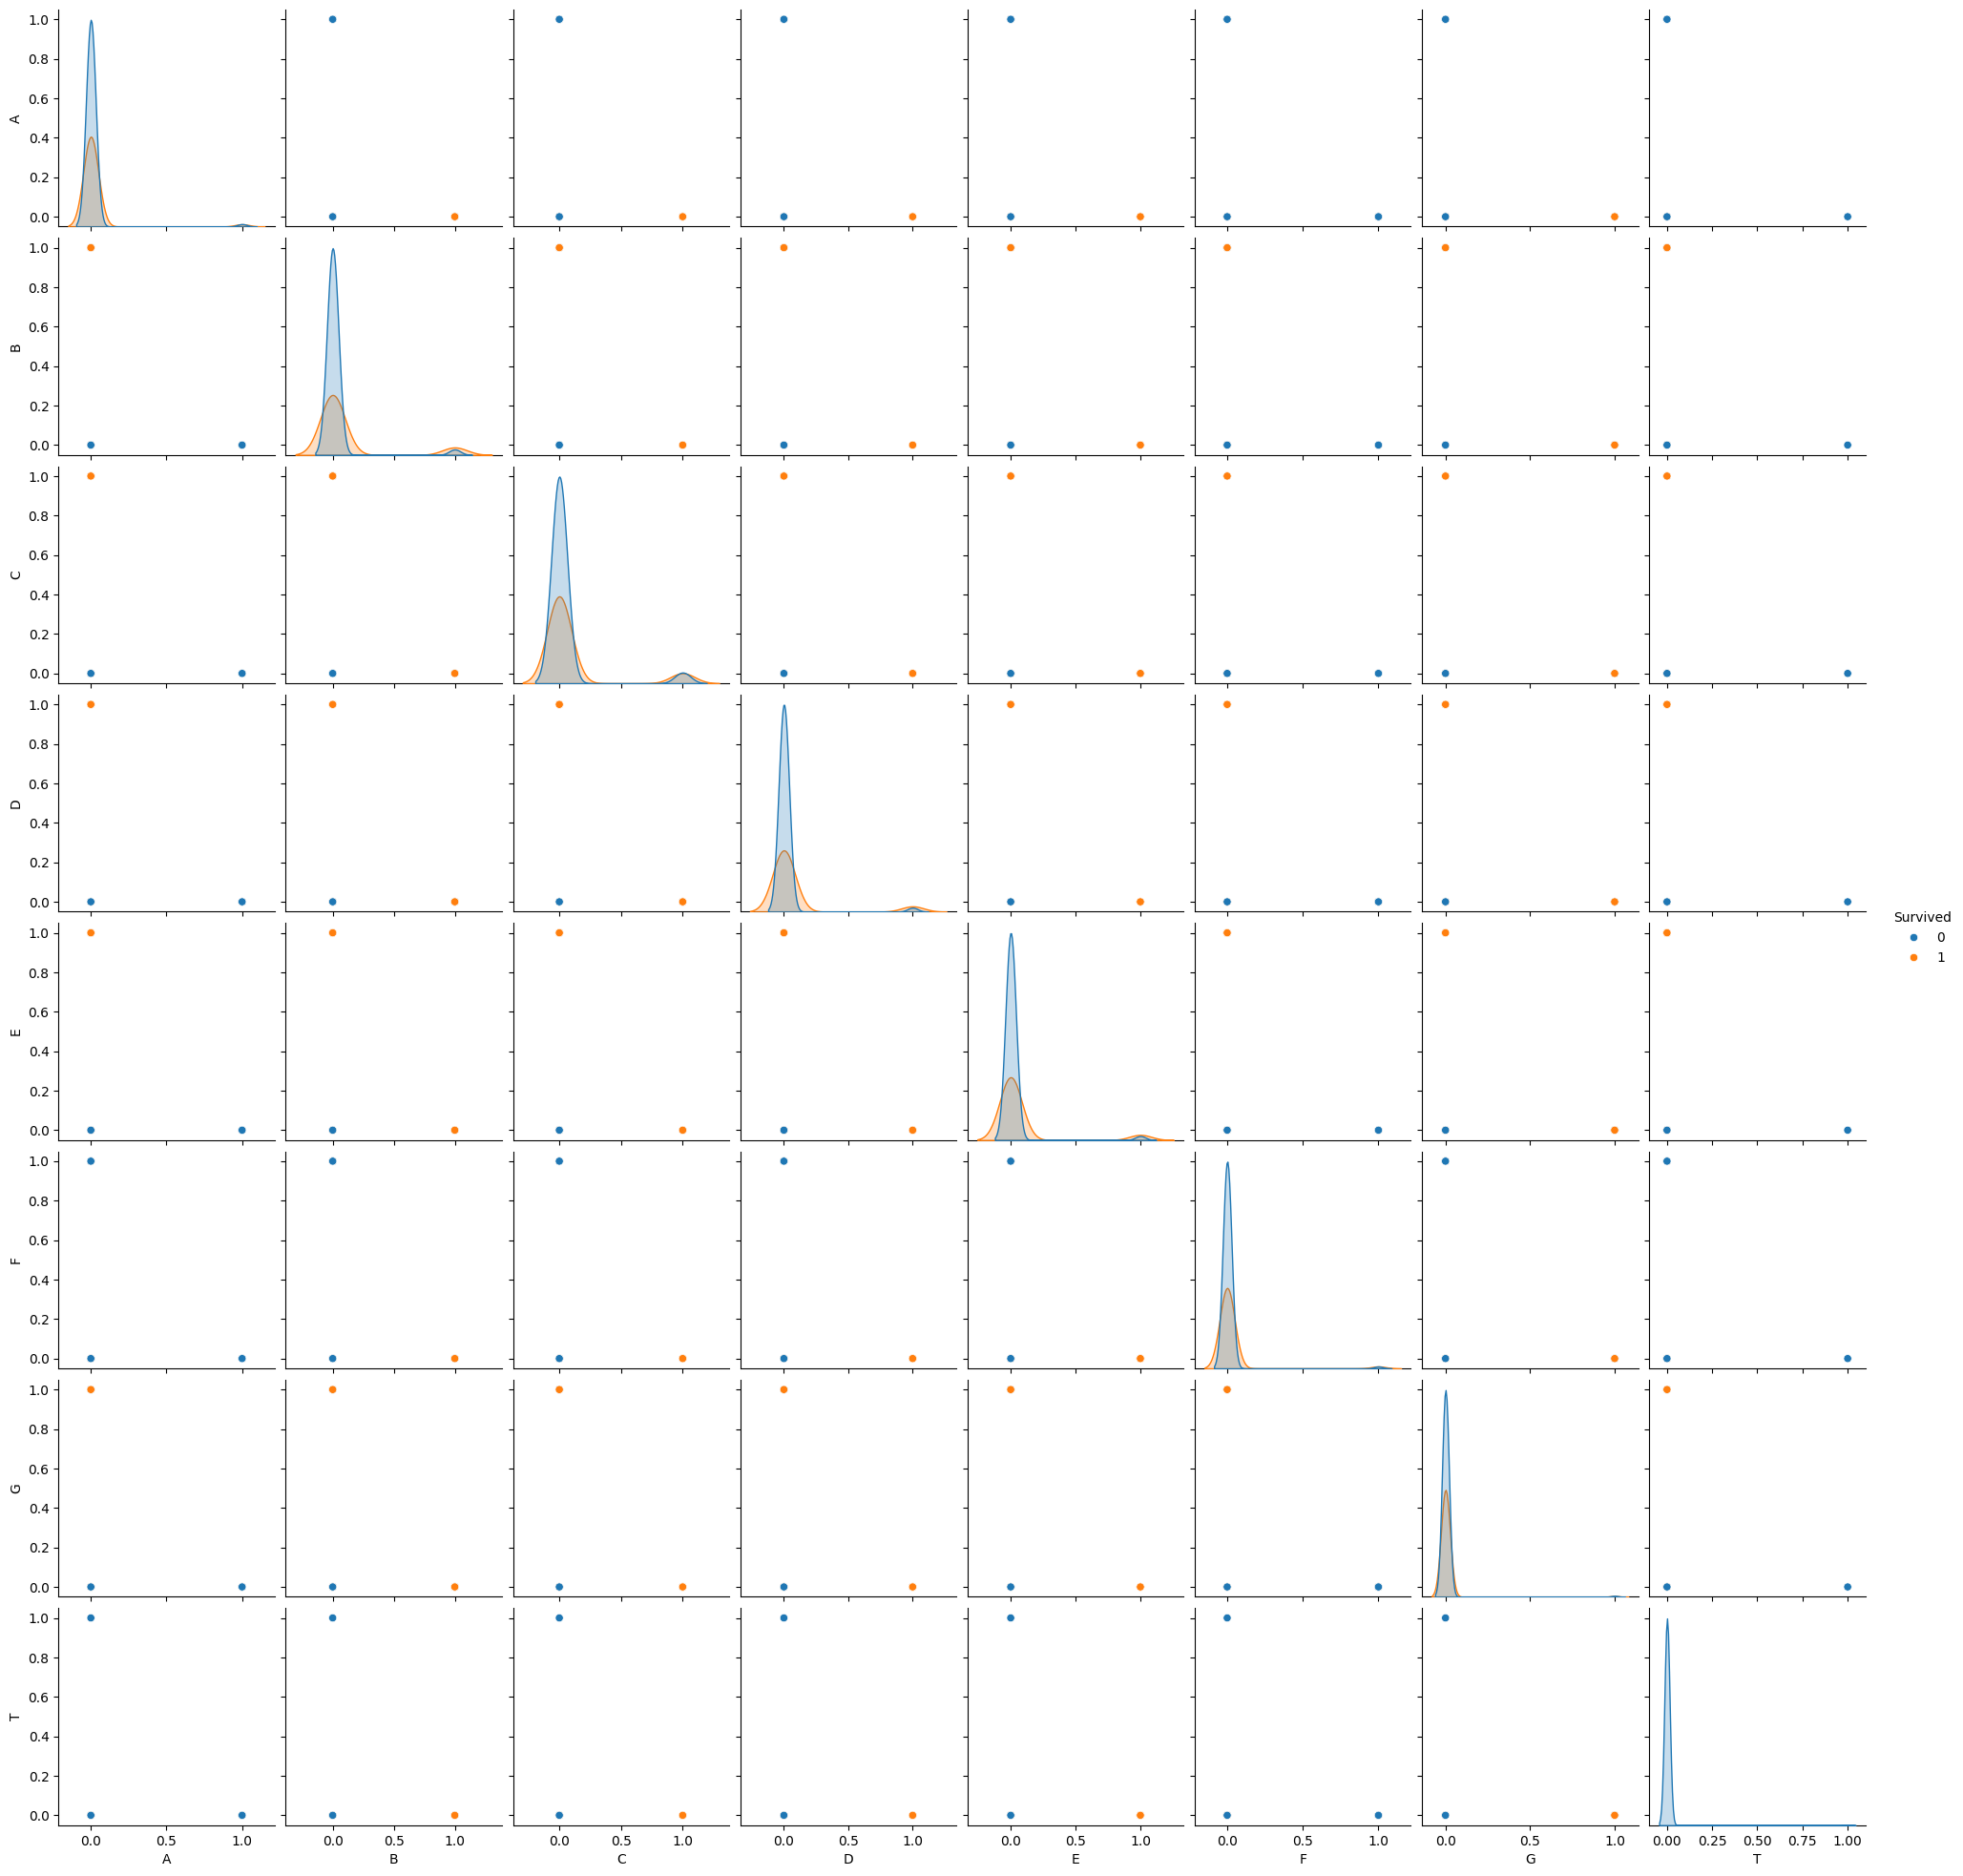

In [7]:

plt.figure()
#df.describe(include="all")
new = df.dropna()
# plt.figure()
sns.pairplot(new, vars = ['Sex','Fare','Pclass'],hue = "Survived",height = 1)
# plt.show()

#sns.pairplot(df, vars = ['A','B','C','D','E','F','G','T'],hue = "Survived")

plt.show()

Testing